### 3. Which metrics correlate with perception? (multiple audio samples)

In [1]:
################## IMPORT LIBRARIES ##################
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import soundfile as sf
from IPython.display import Audio, display, HTML
import torch
from os.path import join as pjoin


In [2]:
################## IMPORT MY MODULES ##################
sys.path.append('../src')

import helpers as hlp
import evaluation
import dataset as ds
import trainer
import models
import loss_mel, loss_stft, loss_waveform, loss_embedd

importlib.reload(evaluation)
importlib.reload(hlp)
importlib.reload(ds)
importlib.reload(trainer)
importlib.reload(models)
importlib.reload(loss_mel)
importlib.reload(loss_stft)
importlib.reload(loss_waveform)
importlib.reload(loss_embedd)


/home/ubuntu/Data/joanna-venvs/wave-u-net2/lib/python3.8/site-packages/pysepm/qualityMeasures.py:121: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def lpcoeff(speech_frame, model_order):
/home/ubuntu/Data/joanna-venvs/wave-u-net2/lib/python3.8/site-packages/pysepm/qualityMeasures.py:209: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def find_loc_peaks(slope,ene

<module 'loss_embedd' from '/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/loss_embedd.py'>

In [3]:
################## LOAD CSV WITH EVALUATION RESULTS ##################
df=pd.read_csv("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-20-05-2024/100924_compare_percept_5000testset.csv")
display(df.head(-20))

,label,idx,compared,1L_multi-stft-mag,1L_stft-mag,1L_multi-wave,1L_wave,1L_logmel,1L_multi-mel,1S_sisdr,...,2L_stft,2S_pesq,2S_stoi,3D_pesq,3D_stoi,3D_sisdr,3D_mos_nidiff,3D_pesq_nidiff,3D_stoi_nidiff,3D_sisdr_nidiff
0,oracle,0,target:content,0.600634,0.583605,0.068631,0.066960,1.921033,0.215623,2.658916,...,1.244879,1.705557,0.862720,0.798228,0.026857,0.134517,0.003540,0.138978,2.033812,16.357029
1,oracle,0,target:anecho,0.496922,0.483700,0.052318,0.054010,0.835397,0.140950,3.404465,...,1.029766,1.965661,0.932157,2.354378,0.066631,95.583878,0.021989,0.041404,0.266058,2.118225
2,oracle,0,target:style,1.826192,1.820626,0.315564,0.401128,23.977242,0.921348,-35.319828,...,3.527072,1.124810,0.073743,1.189633,0.792185,37.176315,0.770872,0.042380,0.245197,1.362411
3,oracle,0,target:targetclone,0.320246,0.319561,0.045844,0.037407,0.240898,0.077551,5.599850,...,0.790806,3.054476,0.939580,0.139787,0.003636,0.164862,0.004823,0.018988,0.001153,1.468706
4,oracle,1,target:content,0.435575,0.426848,0.048668,0.050350,0.611915,0.122099,1.337802,...,1.017734,2.229594,0.899522,0.098998,0.020601,4.335567,1.088028,0.021208,0.036832,0.367189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69975,18-06-2024--18-37_c_wunet_stft_1_checkpoint0,4975,prediction:target,0.367274,0.362153,0.078434,0.080032,0.529716,0.115439,4.105697,...,0.933378,1.831288,0.867034,0.081442,0.019996,1.326015,0.010838,0.001500,0.092972,0.777324
69976,18-06-2024--18-37_c_wunet_stft_1_checkpoint0,4976,prediction:target,0.749455,0.736296,0.077597,0.093038,1.538749,0.195088,-0.170225,...,1.321337,2.087778,0.844369,0.008417,0.047474,4.318907,0.351894,0.096167,1.030144,9.559963
69977,18-06-2024--18-37_c_wunet_stft_1_checkpoint0,4977,prediction:target,0.345481,0.348262,0.041564,0.045438,1.809053,0.212672,5.465498,...,1.126435,1.667404,0.920284,0.973020,0.024331,1.075823,0.028740,0.050058,1.537542,10.069665
69978,18-06-2024--18-37_c_wunet_stft_1_checkpoint0,4978,prediction:target,0.463896,0.453159,0.070609,0.066366,1.006859,0.152232,2.099103,...,1.093523,1.550969,0.863288,0.174622,0.044597,1.287833,1.384480,0.033946,0.398997,2.620199


In [4]:
################## GIVE MORE CONCISE TAGS FOR EACH CATEGORY ##################

def impove_categories_tags(df): 
       # add a column to store a shorter tag identifying each category
       df['short_label'] = df['label'].apply(lambda x: x.split('_', 1)[1] if "_" in x else x)
       df['short_label'] = df['short_label'].apply(lambda x: x.replace("checkpoint","ch"))
       df['tag'] = df['short_label']+ ' -> ' + df['compared']
       df['tag'] = df['tag'].apply(lambda x: x.replace("target","tar"))
       df['tag'] = df['tag'].apply(lambda x: x.replace("prediction","pred"))
       df=df.sort_values("compared")
       df=df.drop(columns=['short_label'])
       # create a custom order of the files so that the plots have similar order as before
       custom_order=["oracle -> tar:anecho", "oracle -> tar:tarclone" , "oracle -> tar:content", "oracle -> tar:style", "anecho+fins -> pred:tar", "dfnet+fins -> pred:tar", "wpe+fins -> pred:tar",
              "c_wunet_stft+wave_0.8_0.2_chbest -> pred:tar", "c_wunet_logmel+wave_0.8_0.2_chbest -> pred:tar", "c_wunet_logmel_1_chbest -> pred:tar", "c_wunet_stft_1_chbest -> pred:tar",
              "c_wunet_stft_1_ch50 -> pred:tar", "c_wunet_stft_1_ch10 -> pred:tar", "c_wunet_stft_1_ch0 -> pred:tar"]
       df['tag'] = pd.Categorical(df['tag'], categories=custom_order, ordered=True)
       df=df.sort_values("tag")
       return df

df=impove_categories_tags(df)

In [5]:
################## ADD COLUMN TO KNOW IF THE SAMPLE IS REV2DRY OR DRY2REV ##################

# divide into re-reverbaration, de-reverberation 
config=hlp.load_config(pjoin("/home/ubuntu/joanna/reverb-match-cond-u-net/config/basic.yaml"))

def get_reverb_ind(config, df, split):
    config["p_noise"]=0
    config["split"]=split
    dataset=ds.DatasetReverbTransfer(config)
    indices_dry2rev=dataset.get_idx_with_rt60diff(-3,-0.3)
    indices_rev2dry=dataset.get_idx_with_rt60diff(0.3,3)
    indices_smalldiff=dataset.get_idx_with_rt60diff(-0.3,0.3)
    df.loc[df["idx"].isin(indices_dry2rev), "rev_delta"] = "dry2rev"
    df.loc[df["idx"].isin(indices_rev2dry), "rev_delta"] = "rev2dry"
    df.loc[df["idx"].isin(indices_smalldiff), "rev_delta"] = "smalldiff"
    return df 

df=get_reverb_ind(config, df, "test")


display(df.head(10))


,label,idx,compared,1L_multi-stft-mag,1L_stft-mag,1L_multi-wave,1L_wave,1L_logmel,1L_multi-mel,1S_sisdr,...,2S_stoi,3D_pesq,3D_stoi,3D_sisdr,3D_mos_nidiff,3D_pesq_nidiff,3D_stoi_nidiff,3D_sisdr_nidiff,tag,rev_delta
8473,oracle,2118,target:anecho,0.369381,0.374092,0.037068,0.034815,6.943845,0.385426,4.841435,...,0.879105,2.932034,0.115111,89.802589,0.001214,0.108536,1.874333,6.316578,oracle -> tar:anecho,NaN
2013,oracle,503,target:anecho,0.657358,0.622022,0.088839,0.086272,1.791984,0.226027,1.872985,...,0.923715,3.252885,0.069180,95.262482,0.223579,0.069560,1.864454,16.872202,oracle -> tar:anecho,NaN
1865,oracle,466,target:anecho,0.405429,0.407728,0.098625,0.088040,3.103537,0.272407,4.323186,...,0.918775,3.489628,0.071057,96.110146,1.236505,0.075325,2.563537,19.523094,oracle -> tar:anecho,NaN
18757,oracle,4689,target:anecho,0.320307,0.315601,0.055988,0.051232,1.218513,0.151358,5.774079,...,0.912989,2.420361,0.090231,92.623260,0.053194,0.073646,1.453827,17.713226,oracle -> tar:anecho,NaN
1861,oracle,465,target:anecho,0.381978,0.383697,0.057916,0.057605,1.746760,0.216660,4.681594,...,0.891779,3.274585,0.099039,93.608261,0.776060,0.134478,2.215208,13.887040,oracle -> tar:anecho,NaN
18845,oracle,4711,target:anecho,0.411745,0.416070,0.035972,0.033495,1.481113,0.189563,3.790096,...,0.909427,3.200450,0.083713,91.977036,0.031937,0.026483,0.774776,4.694230,oracle -> tar:anecho,NaN
1713,oracle,428,target:anecho,0.451235,0.451781,0.083613,0.075340,1.709558,0.222386,0.959255,...,0.860123,3.096629,0.128860,99.344910,1.323946,0.209165,2.613453,22.256050,oracle -> tar:anecho,NaN
18857,oracle,4714,target:anecho,0.508655,0.495229,0.036152,0.028457,43.371284,0.795853,4.417091,...,0.868875,3.276534,0.098091,88.536308,0.336062,0.040754,1.848278,5.076106,oracle -> tar:anecho,NaN
1717,oracle,429,target:anecho,0.387770,0.397115,0.077396,0.082506,6.734884,0.393179,5.151758,...,0.899205,3.501525,0.089876,93.278709,0.658592,0.091443,2.333505,16.861050,oracle -> tar:anecho,NaN
18853,oracle,4713,target:anecho,0.400367,0.405606,0.079585,0.074521,2.224285,0.234891,3.970093,...,0.877303,3.254088,0.113353,95.559128,1.716623,0.085157,2.547326,17.983763,oracle -> tar:anecho,NaN


In [6]:
################### FOR EACH SAMPLE INDEX, CHECK IF FOR THAT SAMPLE THE PERCEPTUAL EXPECTATIONS ARE CONFIRMED ##################

def check_requirements(df,idx):

    # get the names and number of metrics used
    df_metrics_only = df.loc[:, ~df.columns.isin(["label","idx","compared","short_label","tag",'rev_delta','dataset'])]
    N_metrics=len(df_metrics_only.columns)

    # get data for one index (for each index several audios: anecho, content, target, processed, etc.)
    df_idx=df[df["idx"]==idx]

    rev_delta=df_idx['rev_delta'].iloc[0]

    # create dictionary to fill for this index
    conditions_dict={"metric": list(df_metrics_only.columns),
                     "idx" : [idx] * N_metrics,
                     "rev_delta" : [rev_delta] * N_metrics,
                     "sTargetClone > sContent" : [False] * N_metrics,
                     "sTargetClone most similar" : [False] * N_metrics,
                     "sContent < sPred_anecho_fins & our best models" : [False] * N_metrics,
                     "sPred_anecho_fins > all our models" : [False] * N_metrics,
                     "sPred_anecho_fins > our logmel model" : [False] * N_metrics,
                     "sPred_anecho_fins > our half-trained models" : [False] * N_metrics,
                     "sPred_anecho_fins > sPred_dfnet_fins & sPred_wpe_fins" :[False] * N_metrics,
                     "stft+wave_0.8_0.2_checkpointbest > logmel+wave_0.8_0.2_checkpointbest" : [False] * N_metrics,
                     "earlier checkpoints < later checkpoints" : [False] * N_metrics}
    
    def note_metric_in_conddict(conditions_dict, key):
        for j,metric in enumerate(conditions_dict["metric"]):
            if metric==col: 
                conditions_dict[key][j]=True
            


    # filtering
    df_idx=df_idx[df_idx["tag"]!= "tar:anecho"]
    df_idx=df_idx[df_idx["tag"]!= "tar:style"]

    row_content = df_idx[df_idx['tag'].str.contains("content")]
    row_targetclone = df_idx[df_idx['tag'].str.contains("tarclone")]

    row_anechofins = df_idx[df_idx['tag'].str.contains("anecho\\+fins")]
    row_dfnetfins = df_idx[df_idx['tag'].str.contains("dfnet\\+fins")]
    row_wpefins = df_idx[df_idx['tag'].str.contains("wpe\\+fins")]

    rows_fins_notanecho=pd.concat([row_dfnetfins,row_wpefins])

    row_ourlogmelwave = df_idx[df_idx['tag'].str.contains("logmel\\+wave_0.8_0.2_chbest")]
    row_ourstftwave = df_idx[df_idx['tag'].str.contains("stft\\+wave_0.8_0.2_chbest")]
    row_ourlogmel = df_idx[df_idx['tag'].str.contains("logmel_1_chbest")]
    row_ourstft = df_idx[df_idx['tag'].str.contains("stft_1_chbest")]

    rows_ourbests=pd.concat([row_ourlogmelwave,row_ourstftwave, row_ourlogmel,row_ourstft])

    row_ourstft0 = df_idx[df_idx['tag'].str.contains("ch0")]
    row_ourstft10 = df_idx[df_idx['tag'].str.contains("ch10")]
    row_ourstft50 = df_idx[df_idx['tag'].str.contains("ch50")]

    rows_ourhalftrained=pd.concat([row_ourstft0,row_ourstft10])
    rows_ourmodels = df_idx[df_idx['tag'].str.contains("_ch")]
    rows_bestpreds = pd.concat([rows_ourbests,row_anechofins])

    
    # sTargetClone is more similar to sTarget than sContent (change in reverb)
    for col in df_idx.columns: 
        if "L_" in col  or "D_" in col:
            if (row_content[col].item() >= row_targetclone[col].item()):  
                note_metric_in_conddict(conditions_dict, "sTargetClone > sContent")
        elif "S_" in col:
            if (row_content[col].item() <= row_targetclone[col].item()): 
                note_metric_in_conddict(conditions_dict, "sTargetClone > sContent")

    # sTargetClone is most similar to sTarget from all the signals
    for col in df_idx.columns:
        sorted_values = df_idx.sort_values(by=col).reset_index(drop=True)
        # loss/difference metrics
        if "L_" in col  or "D_" in col: 
            if sorted_values.loc[sorted_values.index[0], 'tag']=='oracle -> tar:tarclone':  # Check second lowest
                note_metric_in_conddict(conditions_dict, "sTargetClone most similar")
        # similarity metrics
        elif "S_" in col: 
            if sorted_values.loc[sorted_values.index[-1], 'tag']=='oracle -> tar:tarclone':  # Check second lowest
                note_metric_in_conddict(conditions_dict, "sTargetClone most similar")


    # sContent less similar to target than sPred_anecho_fins and our well-trained models
    # i.e. transformation helps
    for col in df_idx.columns: 
        if "L_" in col  or "D_" in col:
            if (rows_bestpreds[col] < row_content[col].item()).all(): 
                note_metric_in_conddict(conditions_dict, "sContent < sPred_anecho_fins & our best models")
        elif "S_" in col:
            if (rows_bestpreds[col] > row_content[col].item()).all(): 
                note_metric_in_conddict(conditions_dict, "sContent < sPred_anecho_fins & our best models")


    # sPred_anecho_fins is better than all of our models
    for col in df_idx.columns: 
        if "L_" in col  or "D_" in col:
            if (rows_ourmodels[col] >= row_anechofins[col].item()).all():  
                note_metric_in_conddict(conditions_dict, "sPred_anecho_fins > all our models")
        elif "S_" in col:
            if (rows_ourmodels[col] <= row_anechofins[col].item()).all(): 
                note_metric_in_conddict(conditions_dict, "sPred_anecho_fins > all our models")

    # sPred_anecho_fins is at least better than logmel model 
    for col in df_idx.columns: 
        if "L_" in col  or "D_" in col:
            if (row_ourlogmelwave[col] >= row_anechofins[col].item()).all():  
                note_metric_in_conddict(conditions_dict, "sPred_anecho_fins > our logmel model")
        elif "S_" in col:
            if (row_ourlogmelwave[col] <= row_anechofins[col].item()).all(): 
                note_metric_in_conddict(conditions_dict, "sPred_anecho_fins > our logmel model")

    # sPred_anecho_fins is at least better than our half-trained models 
    for col in df_idx.columns: 
        if "L_" in col  or "D_" in col:
            if (rows_ourhalftrained[col] >= row_anechofins[col].item()).all():  
                note_metric_in_conddict(conditions_dict, "sPred_anecho_fins > our half-trained models")
        elif "S_" in col:
            if (rows_ourhalftrained[col] <= row_anechofins[col].item()).all(): 
                note_metric_in_conddict(conditions_dict, "sPred_anecho_fins > our half-trained models")

    # sPred_anecho_fins is better than sPred_dfnet_fins and sPred_wpe_fins
    for col in df_idx.columns: 
        if "L_" in col  or "D_" in col:
            if (rows_fins_notanecho[col] > row_anechofins[col].item()).all(): 
                note_metric_in_conddict(conditions_dict, "sPred_anecho_fins > sPred_dfnet_fins & sPred_wpe_fins")
        elif "S_" in col:
            if (rows_fins_notanecho[col] < row_anechofins[col].item()).all():  
                note_metric_in_conddict(conditions_dict, "sPred_anecho_fins > sPred_dfnet_fins & sPred_wpe_fins")


    # stft+wave_0.8_0.2_checkpointbest better than logmel+wave_0.8_0.2_checkpointbest
    for col in df_idx.columns: 
        if "L_" in col  or "D_" in col:
            if (row_ourlogmel[col].item() > row_ourstft[col].item()): 
                note_metric_in_conddict(conditions_dict, "stft+wave_0.8_0.2_checkpointbest > logmel+wave_0.8_0.2_checkpointbest")
        elif "S_" in col:
            if (row_ourlogmel[col].item() < row_ourstft[col].item()):  
                note_metric_in_conddict(conditions_dict, "stft+wave_0.8_0.2_checkpointbest > logmel+wave_0.8_0.2_checkpointbest")

    # checkpoint0 <  checkpoint10 < checkpoint50
    for col in df_idx.columns: 
        if "L_" in col  or "D_" in col:
            if (row_ourstft0[col].item() > row_ourstft10[col].item() and 
            row_ourstft10[col].item() > row_ourstft50[col].item()): 
                note_metric_in_conddict(conditions_dict, "earlier checkpoints < later checkpoints")
        elif "S_" in col:
            if (row_ourstft0[col].item() < row_ourstft10[col].item() and 
            row_ourstft10[col].item() < row_ourstft50[col].item()): 
                note_metric_in_conddict(conditions_dict, "earlier checkpoints < later checkpoints")

    return conditions_dict
    # end of function "check_requirements(df,idx)"


# get unique indices
unique_idx=df.idx.unique()

# initialize empty dictionary
keys=["metric",
      "idx",
      "rev_delta",
      "sTargetClone > sContent",
      "sTargetClone most similar",
      "sContent < sPred_anecho_fins & our best models" ,
       "sPred_anecho_fins > all our models" ,
       "sPred_anecho_fins > our logmel model" ,
       "sPred_anecho_fins > our half-trained models"  ,
        "sPred_anecho_fins > sPred_dfnet_fins & sPred_wpe_fins" ,
        "stft+wave_0.8_0.2_checkpointbest > logmel+wave_0.8_0.2_checkpointbest" ,
       "earlier checkpoints < later checkpoints" ]
combined_dict =  {key: [] for key in keys}

i=0
for idx in unique_idx:
    i+=1
    tmp_dict=check_requirements(df,idx)
    combined_dict = {key: combined_dict[key] + tmp_dict[key] for key in keys}

# go from dictionary to df
df_table=pd.DataFrame(combined_dict)
display(df_table.head(10))

,metric,idx,rev_delta,sTargetClone > sContent,sTargetClone most similar,sContent < sPred_anecho_fins & our best models,sPred_anecho_fins > all our models,sPred_anecho_fins > our logmel model,sPred_anecho_fins > our half-trained models,sPred_anecho_fins > sPred_dfnet_fins & sPred_wpe_fins,stft+wave_0.8_0.2_checkpointbest > logmel+wave_0.8_0.2_checkpointbest,earlier checkpoints < later checkpoints
0,1L_multi-stft-mag,2118,NaN,True,False,True,False,False,False,True,True,True
1,1L_stft-mag,2118,NaN,True,False,True,False,False,False,True,True,True
2,1L_multi-wave,2118,NaN,True,False,True,False,False,True,True,True,True
3,1L_wave,2118,NaN,True,False,False,False,False,True,True,False,True
4,1L_logmel,2118,NaN,True,False,True,False,False,False,True,True,True
5,1L_multi-mel,2118,NaN,True,False,True,False,False,False,True,True,True
6,1S_sisdr,2118,NaN,True,False,False,False,False,False,True,True,True
7,1L_emb_euc,2118,NaN,True,False,True,True,True,True,True,False,False
8,2L_lsd,2118,NaN,True,False,True,False,False,False,True,True,True
9,2L_mcd,2118,NaN,True,False,True,False,False,False,True,True,True


In [8]:
####################  CREATE A TABLE INDICATING WHICH PERCEPTUAL OBSERVATIONS ARE CONFIRMED BY EACH METRIC ################### 
# CASE 1 -> ALLDATA

needed_columns = df_table.drop(columns=["idx","rev_delta"],axis=1)
df_table_g=needed_columns.groupby("metric").agg(lambda x: int((x.sum() / len(x))*100)).reset_index()
df_table_g = df_table_g.style.background_gradient(cmap='viridis', vmin=0, vmax=100,)
display(df_table_g)

,metric,sTargetClone > sContent,sTargetClone most similar,sContent < sPred_anecho_fins & our best models,sPred_anecho_fins > all our models,sPred_anecho_fins > our logmel model,sPred_anecho_fins > our half-trained models,sPred_anecho_fins > sPred_dfnet_fins & sPred_wpe_fins,stft+wave_0.8_0.2_checkpointbest > logmel+wave_0.8_0.2_checkpointbest,earlier checkpoints < later checkpoints
0,1L_emb_euc,79,27,53,24,44,52,56,53,42
1,1L_logmel,93,86,37,18,26,40,95,75,69
2,1L_multi-mel,89,73,35,8,12,27,91,59,68
3,1L_multi-stft-mag,74,24,28,2,10,17,80,87,72
4,1L_multi-wave,75,32,29,8,21,31,71,65,56
5,1L_stft-mag,74,24,28,2,9,16,79,86,71
6,1L_wave,67,28,21,10,30,30,62,70,47
7,1S_sisdr,78,17,14,0,6,5,89,99,84
8,2L_lsd,96,83,31,9,15,19,98,89,80
9,2L_mcd,94,66,22,2,3,11,96,75,81


In [9]:
####################  CREATE A TABLE INDICATING WHICH PERCEPTUAL OBSERVATIONS ARE CONFIRMED BY EACH METRIC ################### 
# CASE 2 -> REV2DRY

df_table_rev2dry=df_table[df_table["rev_delta"]=="rev2dry"]

needed_columns = df_table_rev2dry.drop(columns=["idx","rev_delta"],axis=1)
df_table_g=needed_columns.groupby("metric").agg(lambda x: int((x.sum() / len(x))*100)).reset_index()
df_table_g = df_table_g.style.background_gradient(cmap='viridis', vmin=0, vmax=100,)
display(df_table_g)

,metric,sTargetClone > sContent,sTargetClone most similar,sContent < sPred_anecho_fins & our best models,sPred_anecho_fins > all our models,sPred_anecho_fins > our logmel model,sPred_anecho_fins > our half-trained models,sPred_anecho_fins > sPred_dfnet_fins & sPred_wpe_fins,stft+wave_0.8_0.2_checkpointbest > logmel+wave_0.8_0.2_checkpointbest,earlier checkpoints < later checkpoints
0,1L_emb_euc,88,11,77,0,22,11,66,44,44
1,1L_logmel,88,88,44,11,11,22,100,88,55
2,1L_multi-mel,88,88,44,0,0,22,88,66,44
3,1L_multi-stft-mag,55,11,11,0,0,0,88,88,66
4,1L_multi-wave,88,55,0,0,11,11,88,66,33
5,1L_stft-mag,55,11,11,0,0,0,88,88,66
6,1L_wave,77,22,0,0,11,33,88,77,22
7,1S_sisdr,77,11,0,0,0,0,100,100,77
8,2L_lsd,88,88,33,11,11,22,100,100,66
9,2L_mcd,88,55,22,0,0,0,100,88,66


In [10]:
####################  CREATE A TABLE INDICATING WHICH PERCEPTUAL OBSERVATIONS ARE CONFIRMED BY EACH METRIC ################### 
# CASE 2 -> DRY2REV

df_table_dry2rev=df_table[df_table["rev_delta"]=="dry2rev"]

needed_columns = df_table_dry2rev.drop(columns=["idx","rev_delta"],axis=1)
df_table_g=needed_columns.groupby("metric").agg(lambda x: int((x.sum() / len(x))*100)).reset_index()
df_table_g = df_table_g.style.background_gradient(cmap='viridis', vmin=0, vmax=100,)
display(df_table_g)

,metric,sTargetClone > sContent,sTargetClone most similar,sContent < sPred_anecho_fins & our best models,sPred_anecho_fins > all our models,sPred_anecho_fins > our logmel model,sPred_anecho_fins > our half-trained models,sPred_anecho_fins > sPred_dfnet_fins & sPred_wpe_fins,stft+wave_0.8_0.2_checkpointbest > logmel+wave_0.8_0.2_checkpointbest,earlier checkpoints < later checkpoints
0,1L_emb_euc,80,40,46,33,46,46,33,46,46
1,1L_logmel,86,86,26,13,26,33,93,100,66
2,1L_multi-mel,86,60,33,0,6,13,86,80,73
3,1L_multi-stft-mag,60,26,26,0,20,20,66,86,60
4,1L_multi-wave,66,33,26,13,26,53,60,60,53
5,1L_stft-mag,66,26,26,0,13,13,66,86,60
6,1L_wave,60,13,20,13,20,26,40,66,66
7,1S_sisdr,73,13,13,0,6,6,86,100,66
8,2L_lsd,93,80,33,13,13,13,100,86,60
9,2L_mcd,80,53,13,0,0,13,93,80,60


In [11]:
####################  CREATE A TABLE INDICATING WHICH PERCEPTUAL OBSERVATIONS ARE CONFIRMED BY EACH METRIC ################### 
# CASE 2 -> SMALLDIFF

df_table_smalldiff=df_table[df_table["rev_delta"]=="smalldiff"]

needed_columns = df_table_smalldiff.drop(columns=["idx","rev_delta"],axis=1)
df_table_g=needed_columns.groupby("metric").agg(lambda x: int((x.sum() / len(x))*100)).reset_index()
df_table_g = df_table_g.style.background_gradient(cmap='viridis', vmin=0, vmax=100,)
display(df_table_g)

,metric,sTargetClone > sContent,sTargetClone most similar,sContent < sPred_anecho_fins & our best models,sPred_anecho_fins > all our models,sPred_anecho_fins > our logmel model,sPred_anecho_fins > our half-trained models,sPred_anecho_fins > sPred_dfnet_fins & sPred_wpe_fins,stft+wave_0.8_0.2_checkpointbest > logmel+wave_0.8_0.2_checkpointbest,earlier checkpoints < later checkpoints
0,1L_emb_euc,69,3,57,19,42,46,57,61,57
1,1L_logmel,92,88,46,11,30,34,96,76,69
2,1L_multi-mel,88,76,53,0,11,15,88,46,76
3,1L_multi-stft-mag,80,19,23,0,11,11,76,88,84
4,1L_multi-wave,88,30,38,3,19,19,65,50,73
5,1L_stft-mag,76,19,23,0,11,11,76,84,80
6,1L_wave,76,30,38,3,30,23,57,76,57
7,1S_sisdr,84,15,7,0,0,0,88,96,92
8,2L_lsd,100,88,42,3,15,19,96,92,73
9,2L_mcd,96,69,30,0,0,3,96,65,76


### Conclusions: 

- Results for multiple audio samples are similar to the results for 1 audio sample
- Most of the metrics "see" the difference in reverb (even when the difference in rt60 is small)
- Metrics get confused when dealing with artificially processed sounds (for example, if the model was trained with the stft loss, the stft_loss(processed, target) is smaller than stft_loss(targetclone, target). This does not reflect the perception.
- When delta in the rt60 is small, there is not much benefit in processing the data (see column "sContent < sPred_anecho_fins & our best models"), but when the rt60 delta is big it gets better. 
- When delta in the rt60 is small, there less benefit in training longer (see difference between early and late checkpoints)
- It looks like for a large rt60 delta, the perceptual effect that the baseline sPred_anecho_fins is better than our models is sometimes confirmed by some metrics (see 3 middle columns). This perceptual effect is confirmed more often than when rt60 delta is small...

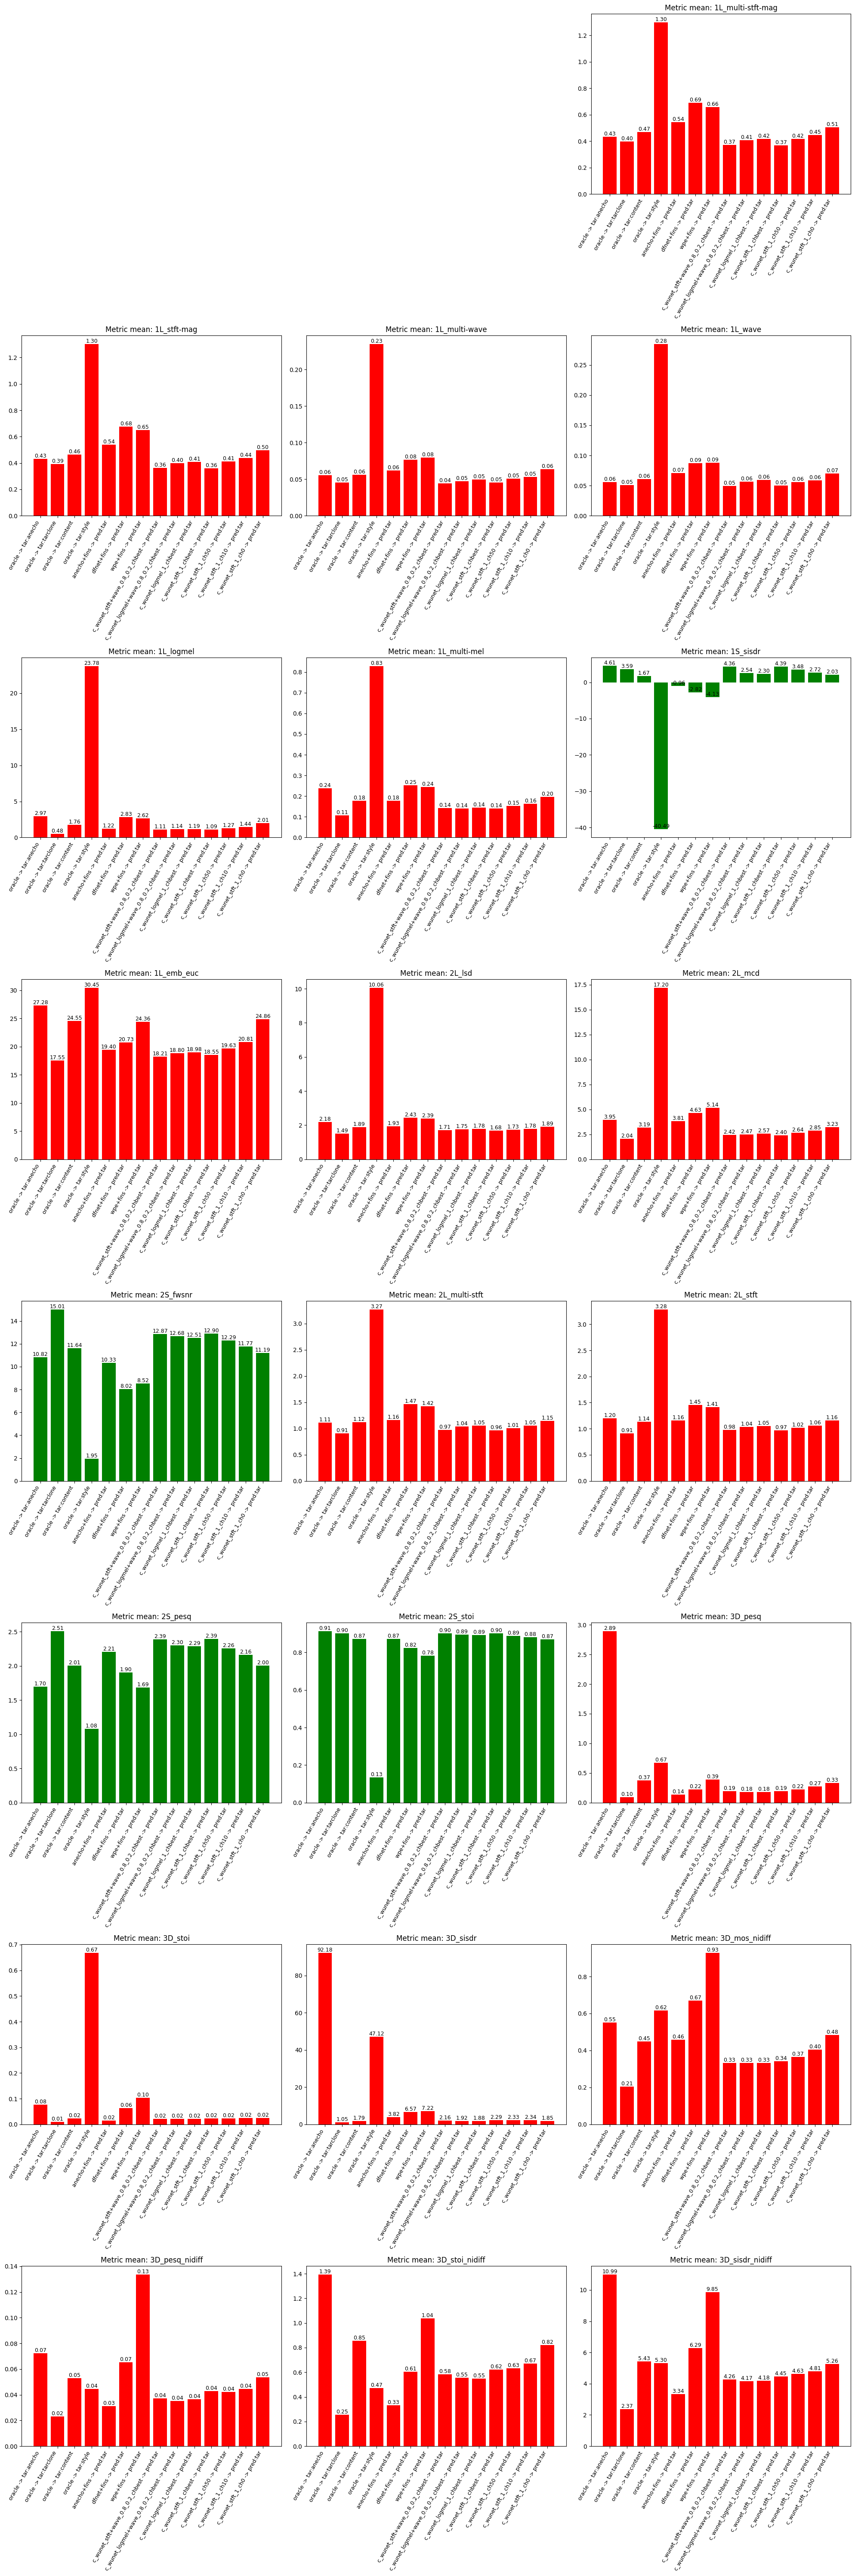

In [12]:
# PLOT AVERAGE METRICS 

# create df with average metric across data points
numeric_df = df.select_dtypes(include='number')
df_g=df.groupby("tag")[numeric_df.columns].mean().reset_index()

# plot average metrics
plt.figure(figsize=(20,60))
N_metrics=len(df_g.columns)
for i, column in enumerate(df_g.columns):
    if column not in ["label", "idx", "compared","short_label","tag"]:    
        N_rows=int(np.ceil(N_metrics/3))
        metriccolor="red" if "D_" in column or "L_" in column else "green"
        plt.subplot(N_rows,3,i+1)
        bars=plt.bar(df_g["tag"],df_g[column], color=metriccolor)
        plt.xticks(rotation=60, ha='right', fontsize="9")
        plt.title("Metric mean: " + column)
        for j,bar in enumerate(bars):
            val4clone=bars[j].get_height()#df_idx[column][df_idx["label"]=="sTarget : sAnecho"][0]
            plt.text(j,val4clone,str("%.2f" % val4clone), horizontalalignment='center',verticalalignment='bottom', fontsize="9")
plt.tight_layout()
plt.show()

